<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [1]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
bs = 32
labeled_bs = 32
test_bs = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005


batch_size = 512
temp = 0.1

contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [3]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#normalize
x_train = x_train/255
x_test = x_test/255

#lets devide the test to labeled train and test
x_train_labeled = x_test[:5000]
y_train_labeled = y_test[:5000]

x_test = x_test[5000:]
y_test = y_test[5000:]

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total training labeled images: {x_train_labeled.shape[0]} & Shape of training labeled data: {x_train_labeled.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

170508288/170498071 [==============================] - 11s 0us/step
Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total training labeled images: 5000 & Shape of training labeled data: (5000, 32, 32, 3)
Total testing images: 5000 & Shape of testing data: (5000, 32, 32, 3)


In [4]:
#class for image audmentations

class data_augmentation(layers.Layer):

  def __init__(self, **kwargs):
    super(data_augmentation, self).__init__()

  def call(self, sample):
    
    sample = self.random_apply(self.color_jitter, sample, 0.8)
    sample = self.random_apply(self.color_drop, sample, 0.2)    

    return sample

  def color_jitter(self, x, s = 1, p = 0.8):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta = 0.8 * s)
    x = tf.image.random_contrast(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta = 0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(self, x, p = 0.2):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1, 3])
    return x

  def random_apply(self, func, x, p):
    return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#create the data augmentation pipline
data_aug = tf.keras.models.Sequential([tf.keras.layers.Lambda(data_augmentation()), tf.keras.layers.RandomCrop(24, 24), tf.keras.layers.Resizing(32, 32)])

In [5]:
#create tensorflow dataset objects

#create two datasets
train_ds_unlabeled = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_unlabeled = (train_ds_unlabeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

train_ds_labeled = tf.data.Dataset.from_tensor_slices((x_train_labeled, y_train_labeled))
train_ds_labeled = (train_ds_labeled.shuffle(1024, seed = random_seed).batch(batch_size).prefetch(AUTO))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds.batch(batch_size).prefetch(AUTO))

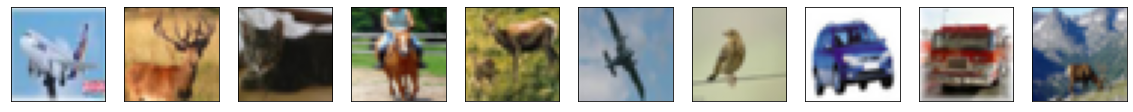

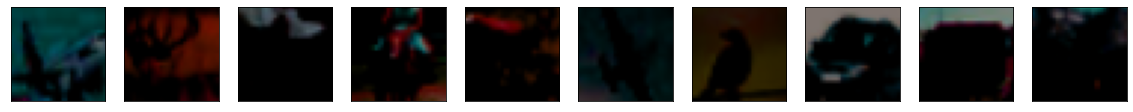

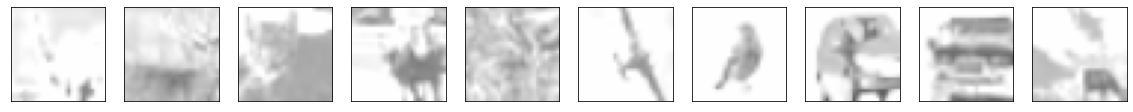

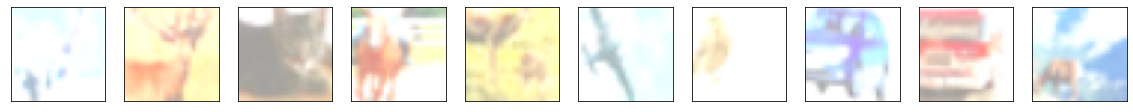

In [6]:
#checkout the augmentations
samp, lab = next(iter(train_ds_unlabeled))

def plot_images(samp):
  #plot figure
  fig, ax = plt.subplots(1, 10, figsize = (20, 2))
  
  for i, s in enumerate(samp[:10]):
    ax[i].imshow(s)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plot_images(samp)
plot_images(data_aug(samp))
plot_images(data_aug(samp))
plot_images(data_aug(samp))

In [33]:
#resnet 
def base_encoder():
  #get the resnet50 model
  base_model = tf.keras.applications.ResNet50(include_top = False, weights = None, input_shape = (32, 32, 3))
  base_model.trainable = True
  
  #define input
  input = tf.keras.layers.Input((32, 32, 3))

  #model
  x = base_model(input, training = True)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  output = tf.keras.layers.Dense(512, activation = 'relu')(x)

  return tf.keras.Model(input, output)

In [34]:
# #see the resnet50 model performance
base = base_encoder()
base.summary()
# resnet50.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.SparseCategoricalCrossentropy(), 
#                  metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'acc')])



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
Total params: 26,210,688
Trainable params: 26,157,568
Non-trainable params: 53,120
_________________________________________________________________


In [35]:
#train the resnet50 model
#base_history = resnet50.fit(train_ds_labeled, epochs = 20, validation_data = test_ds)

In [36]:
# #plot
# plt.figure(figsize = (6, 5))
# plt.plot(np.arange(0, len(base_history.history['val_loss'])), base_history.history['val_loss'], label = 'Validation Loss')
# plt.plot(np.arange(0, len(base_history.history['loss'])), base_history.history['loss'], label = 'Training Loss')
# plt.legend()
# plt.title('Results summary')
# plt.xlabel('Epochs')
# plt.show()

In [38]:
def projection_head():
  #input
  input = tf.keras.layers.Input(shape = (512))
  output = tf.keras.layers.Dense(124, activation = 'relu')(input)

  return tf.keras.Model(input, output)

proj_head = projection_head()
proj_head.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_10 (Dense)            (None, 124)               63612     
                                                                 
Total params: 63,612
Trainable params: 63,612
Non-trainable params: 0
_________________________________________________________________


In [39]:
#sample inputs
xi = tf.random.uniform([16, 32, 32, 3])
xj = tf.random.uniform([16, 32, 32, 3])

In [63]:
#contrastive learning 

#training step
@tf.function
def train_step(xi, xj, base, proj_head, optimizer = None, temp = 1):
  
  with tf.GradientTape() as tape:

    batch_size = xi.shape[0]
    
    #use encoder to get the representations
    hi = base(xi)
    hj = base(xj)

    #get zi and zj from the projection head
    zi = proj_head(hi)
    zj = proj_head(hj)

    #normalize zi and zj
    zi = tf.math.l2_normalize(zi, axis = 1)
    zj = tf.math.l2_normalize(zj, axis = 1)

    #similarity calculation
    similarities = tf.tensordot(tf.expand_dims(zi, 1), tf.expand_dims(tf.transpose(zj), 0))/temp
    
    #similarities = tf.reshape(similarities, (batch_size, 1))

    return None   

In [64]:
train_step(xi, xj, base, proj_head)

TypeError: ignored